In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d gti-upm/leapgestrecog -p /content/

!unzip /content/leapgestrecog.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: /content/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: /

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Step 1: Set Dataset Path
data_dir = '/content/leapGestRecog'

In [ ]:
# Step 2: Load and Preprocess Dataset using ImageDataGenerator
def load_dataset(data_dir):
    image_size = (224, 224)  # Updated for DenseNet
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.3
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True  # Shuffle training data
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.3)
    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False  # No shuffle for validation to ensure consistency
    )

    return train_generator, validation_generator

In [ ]:
# Step 3: Build DenseNet Model
def build_densenet_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze top layers for fine-tuning
    for layer in base_model.layers[:-30]:  # Freeze all layers except the top 30
        layer.trainable = False
    for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Step 4: Train the Model
def train_model(model, train_generator, validation_generator):
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='best_densenet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_generator,
        epochs=15,  # Increased epochs to allow for early stopping
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history

In [ ]:
# Step 5: Evaluate the Model
def evaluate_model(model, validation_generator):
    val_labels = []
    val_preds = []

    for images, labels in validation_generator:
        preds = model.predict(images)
        val_labels.extend(np.argmax(labels, axis=1))
        val_preds.extend(np.argmax(preds, axis=1))

        if len(val_labels) >= validation_generator.samples:
            break

    cm = confusion_matrix(val_labels, val_preds)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(val_labels, val_preds))

    val_probs = model.predict(validation_generator)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(validation_generator.num_classes):
        fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in val_labels], val_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(validation_generator.num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Load dataset
train_gen, val_gen = load_dataset(data_dir)

# Build and train DenseNet model
model = build_densenet_model(num_classes=train_gen.num_classes)
history = train_model(model, train_gen, val_gen)

Found 14000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.4108 - loss: 2.0206
Epoch 1: val_loss improved from inf to 0.76314, saving model to best_densenet_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 285s 566ms/step - accuracy: 0.4112 - loss: 2.0191 - val_accuracy: 0.8528 - val_loss: 0.7631 - learning_rate: 1.0000e-04
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8923 - loss: 0.5517
Epoch 2: val_loss improved from 0.76314 to 0.62222, saving model to best_densenet_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 210s 474ms/step - accuracy: 0.8923 - loss: 0.5515 - val_accuracy: 0.8535 - val_loss: 0.6222 - learning_rate: 1.0000e-04
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9595 - loss: 0.3122
Epoch 3: val_loss improved from 0.62222 to 0.51038, saving model to best_densenet_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 263s 473ms/step - accuracy: 0.9595 - loss: 0.3122 - val_accuracy: 0.8892 - val_loss: 0.5104 - learning_rate: 1.0000e-04
Epoch 4/15
438/438 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

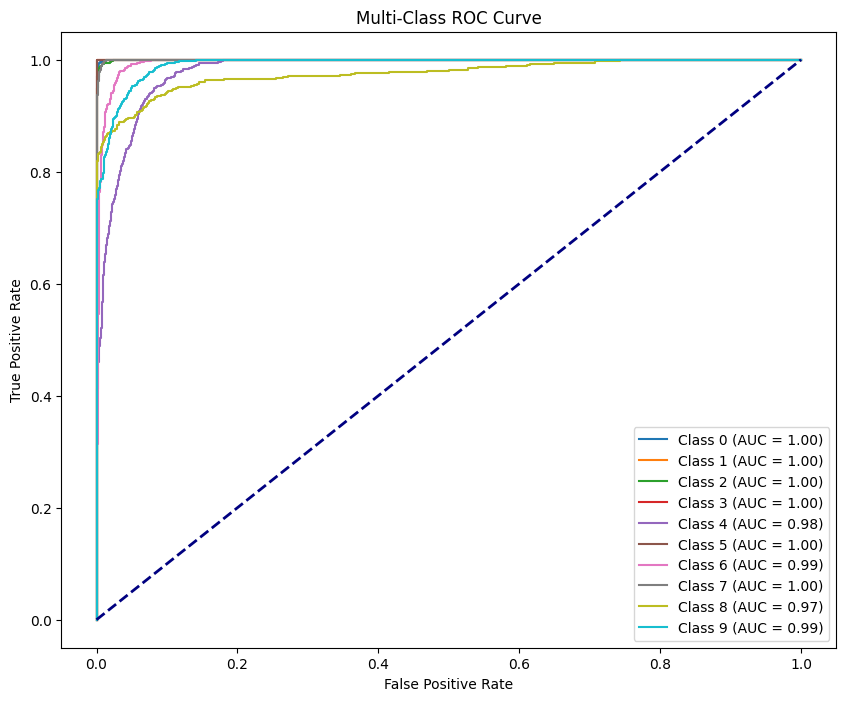

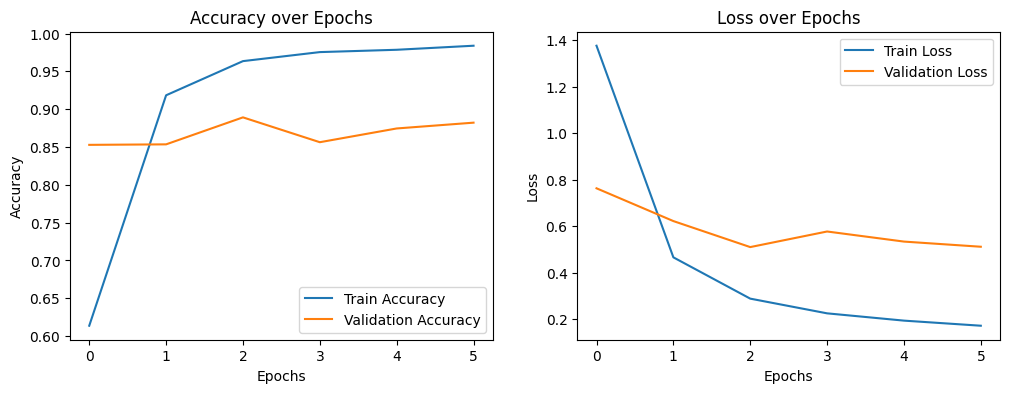

In [ ]:
# Evaluate the model
evaluate_model(model, val_gen)

# Plot Accuracy and Loss over Epochs
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# List files and directories in the "My Drive" folder
drive_path = '/content/drive/My Drive/Colab Notebooks'
files_and_dirs = os.listdir(drive_path)

# Print the list
print(files_and_dirs)

['Copy of DenseNet.ipynb']


In [ ]:
# Define the path to save the model
model_save_path = '/content/drive/My Drive/DenseNet_model/best_densenet_model.keras'

# Save the model
model.save(model_save_path)
print(f"Model saved to Google drive")

Model saved to Google drive
